# Quantum Harmonic Oscillator (Continued)
#### Hunter Lybbert
#### Student ID 2426454
#### 11-01-24

In [1]:
import numpy as np
from scipy.sparse import diags, csr_matrix, dia_matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
from matplotlib import pyplot as plt

## Repeat HW 2

In [2]:
plt.rcParams['grid.linestyle'] = "--"

In [3]:
def my_ode(x: float, y: np.array, epsilon: float) -> np.array:
    return np.array([y[1], (x**2 - epsilon)*y[0]])

def target_bc_end(x:float, epsilon:float, y_0_end: float) -> float:
    return -np.sqrt(x**2 - epsilon)*y_0_end

In [4]:
def homework_two_process():
    """
    This encapsulates everything we did in hw two so we don't mess up any namespace weirdness.

    returns solutions A1 and A2
    """
    eigenvalues = []
    eigenvectors = []


    epsilon_initial = 1
    epsilon_diff = 0.1
    y_at_0 = 1
    xshoot = np.arange(-4, 4.1, 0.1)

    for mode in range(1, 6):

        epsilon_current = epsilon_initial
        epsilon_diff = 0.1

        for _ in range(1000):
            y0 = np.array([y_at_0, np.sqrt(4**2 - epsilon_current)])
            sol = solve_ivp(
                fun=my_ode,
                t_span=(-4, 4),
                y0=y0,
                method="RK45",
                args=(epsilon_current,),
                dense_output=True
            )

            boundary_value_diff = sol.y[1,-1] - target_bc_end(4, epsilon_current, sol.y[0, -1])

            if abs(boundary_value_diff) < 1e-6:
                print(epsilon_current)
                eigenvalues.append(epsilon_current)
                break
            
            elif (-1)**(mode + 1)*boundary_value_diff < 0:
                epsilon_current -= epsilon_diff
                epsilon_diff /= 2

            else:
                epsilon_current += epsilon_diff
                
        epsilon_initial = epsilon_current + 0.1

        eigenvector = sol.sol(xshoot)[0, :]
        trap_norm_of_eigenvector = np.trapezoid(eigenvector*eigenvector, xshoot)
        trap_normalized_eigenvector = eigenvector/np.sqrt(trap_norm_of_eigenvector)

        eigenvectors.append(trap_normalized_eigenvector)

        plt.plot(xshoot, trap_normalized_eigenvector, label=rf"$\lambda_{mode}$")
        plt.legend()
        plt.grid()

    plt.show()

    # The abdsolute value of the first 5 eigenfunctions, this should be (81,5)
    A1 = abs(np.vstack(eigenvectors).T)
    # The corresponding first 5 eigenvalues, this should be (1,5)
    A2 = np.array(eigenvalues)

    return A1, A2

0.9997357911453946
2.9990026018198495
4.9984630555462
6.99758100515118
8.99625425046196


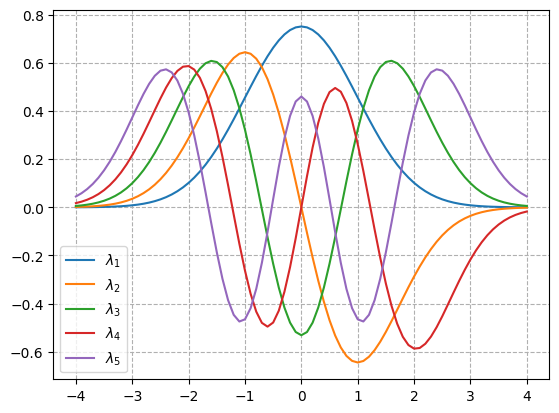

In [5]:
A1, A2 = homework_two_process()

## Actual HW 3
### b)

In [45]:
from enum import Enum

class DerivativeOrder(Enum):
    second = "second"


class FiniteDifferenceMethod(Enum):
    backward = "backward"
    centered = "centered"
    forward = "forward"


def second_deriv_mat(
    size: int,
    step_size: float,
    order: DerivativeOrder = DerivativeOrder.second,
    difference_method: FiniteDifferenceMethod = FiniteDifferenceMethod.centered
) -> np.array:
    """
    :param size: integer of the shape of the derivative matrix, matrix will be (size, size)
    :param step_size: the size of the delta x in the finite different method
    :param order: the order of derivative bing using

    :returns: the difference matrix requested.
    """
    if order == DerivativeOrder.second:
        if difference_method == FiniteDifferenceMethod.centered:
            deriv_mat = (1/(step_size**2))*(
                np.diag(-2*np.ones(size))
                + np.diag(np.ones(size-1), k=1)
                + np.diag(np.ones(size-1), k=-1)
            )
            return deriv_mat

        else:
            raise ValueError(f"{difference_method.name} is not implimented yet")

    else:
        raise ValueError(f"{order.name} is not implimented yet")
    

def build_bc_matrix(
    derivative_matrix: np.array
) -> np.array:
    """
    :param derivative_matrix: the derivative matrix to create bc matrix like

    :returns: build bc matrix with same shape as deriv matrix
    """
    bc_array = np.array([4/3, -1/3])
    bc_matrix = np.zeros_like(derivative_matrix)

    bc_matrix[0,:2] = bc_array
    bc_matrix[-1,-2:] = bc_array[::-1]
    
    return bc_matrix


def get_n_ordered_eigs(
    eig_values: np.array,
    eig_vectors: np.array,
    num_to_get: int = 5,
    ascending: bool = True,
) -> tuple[np.array, np.array]:
    """
    :param eig_values: used to sort/order eigen values and vectors
    :param eig_vectors: eigenvectors to return the subset of
    :param num_to_get: Number of eigenvalues and eigenvectors to grab
    :param ascending: which way to order them before picking the first n

    :returns: first n eigenvalues and eigenvectors when ordered by prescribed ordering
    """
    sorted_indices = np.argsort(eig_values)

    if ascending:
        subset_eig_values = eig_values[sorted_indices][:num_to_get]
        subset_eig_vectors = eig_vectors[:,sorted_indices][:,:num_to_get]
    else:
        subset_eig_values = eig_values[sorted_indices][:-num_to_get]
        subset_eig_vectors = eig_vectors[:,sorted_indices][:,:-num_to_get]

    return subset_eig_values, subset_eig_vectors


def extend_eigenvector(
    eigenvector: np.array
) -> np.array:
    """
    Extend eigenvector to include the first and last points, using the boundary conditions once again.

    :param eigenvector:

    :return: full eigenvector
    """
    phi_0 = (4/3)*eigenvector[0] - (1/3)*eigenvector[1]
    phi_N = - (1/3)*eigenvector[-2] + (4/3)*eigenvector[-1]
    
    eigenvector = np.append([phi_0], eigenvector)
    eigenvector = np.append(eigenvector, [phi_N])

    return eigenvector


def normalize_eigenvector(
    domain: np.array,
    eigenvector: np.array,
) -> np.array:
    """
    :param domain:
    :param eigenvector:

    :return: normalized eigenvector
    """
    assert domain.size == eigenvector.size, ValueError(f"mismatch dimenstions for normalization between {domain.size} and {eigenvector.size}.")


    norm_of_eig_vec = np.trapezoid(eigenvector*eigenvector, domain)
    normalized_eig_vec = eigenvector/np.sqrt(norm_of_eig_vec)

    return normalized_eig_vec


def plot_eigenfunctions(
    domain: np.array,
    eig_values: np.array,
    eig_vectors: np.array,
) -> None:
    """
    Plot the results of the solve.

    :param domain: the domain to plot over
    :param eig_values: the eigenvalues we calculated
    :param eig_vectors: the corresponding eigenvectors

    Plot these!
    """
    for j, eigenvector in enumerate(eig_vectors):

        plt.plot(domain, eigenvector, label=rf"$\lambda_{j+1}$ = {eig_values[j]:.4f}")
        plt.legend()
        plt.grid()

    plt.show()




def direct_solve_hw_three(
    L: int,
    step_size: int,
    plot_results: bool = True,
    absolute_value: bool = True,
    truncate_imaginary: bool = True,
) -> tuple[np.array, np.array]:
    """
    :param L: The integer representing domain to solve on, will be interpreted to solve on [-L, L]
    :param step_size: the step length to use when discretizing [-L, l]
    :param plot_results: bool indicating desire to see plot
    :param absolute_value: bool whether or not to abs plot and returned eig vectors
    :param truncate_imaginary: bool whether or not to truncate imaginary

    :returns: A one dimensional array of eigenvalues and a matrix where each column is an eigenvector
    """
    x_domain = np.arange(
        start=-L,
        stop=L+step_size,
        step=step_size,
    )
    num_points = x_domain.size

    second_deriv_mat_full = second_deriv_mat(
        size=num_points,
        step_size=step_size,
    )
    second_deriv_mat_truncated = second_deriv_mat_full[1:-1,1:-1]
    bc_matrix = build_bc_matrix(second_deriv_mat_truncated)

    domain_truncated = x_domain[1:-1]
    x_squared_mat = np.diag(domain_truncated**2)
    linear_system = -second_deriv_mat_truncated + x_squared_mat + bc_matrix

    eig_values, eig_vectors = la.eig(linear_system)
    first_five_eig_values, first_five_eig_vectors = get_n_ordered_eigs(
        eig_values=eig_values,
        eig_vectors=eig_vectors
    )

    final_eig_vectors = []
    for eig_vec in first_five_eig_vectors.T:
        eig_vec = extend_eigenvector(eig_vec)
        eig_vec = normalize_eigenvector(x_domain, eig_vec)

        final_eig_vectors.append(eig_vec)

    final_eig_vectors = np.vstack(final_eig_vectors)

    if truncate_imaginary:
        first_five_eig_values = np.real(first_five_eig_values)
        
    if absolute_value:
        final_eig_vectors = np.abs(final_eig_vectors)

    if plot_results:
        plot_eigenfunctions(
            domain=x_domain,
            eig_values=first_five_eig_values,
            eig_vectors=final_eig_vectors,
        )
    
    return first_five_eig_values, final_eig_vectors.T


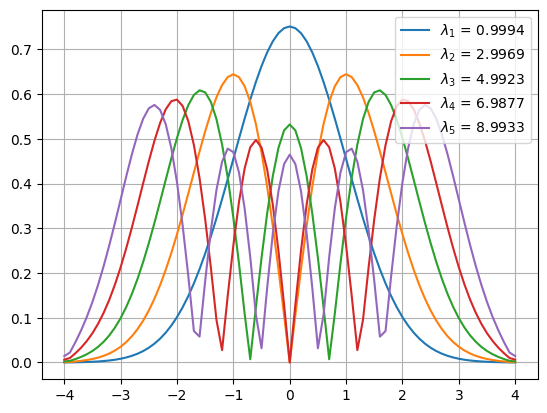

In [46]:
A3, A4 = direct_solve_hw_three(
    L=4,
    step_size=0.1,
    plot_results=True
)